## Import Necessary Packages and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import sys
import pathlib
import PIL
import PIL.Image

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## Custom Data Loader

In [3]:
dataset_dir = "/gdrive/My Drive/Colab Notebooks/m_power_assessment/data/digit"

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15620 files belonging to 10 classes.
Using 12496 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 15620 files belonging to 10 classes.
Using 3124 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
class_names = val_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


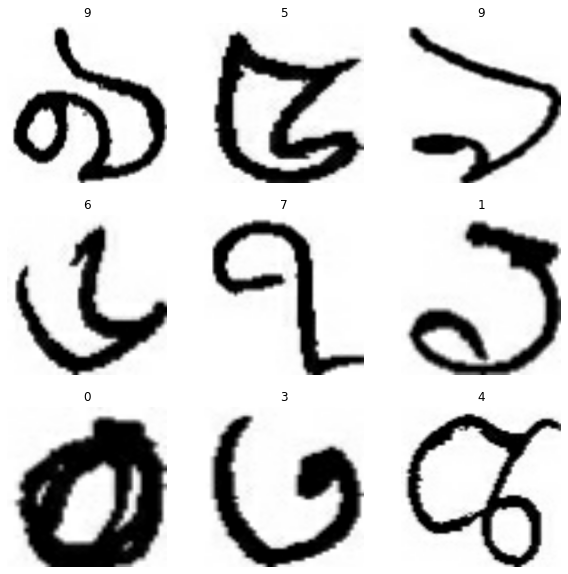

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Data Augmentation

In [11]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

## Model

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)

model = Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
########################################################################################################################
########################################################################################################################
########################################################################################################################

## Defining Custom loss Function and Selection of optimizer

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)

In [19]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

## Custom Training Loop

In [21]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 5

In [22]:
for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_ds:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.159, Accuracy: 27.249%


## Plot of Loss and Accuracy vs Epoch

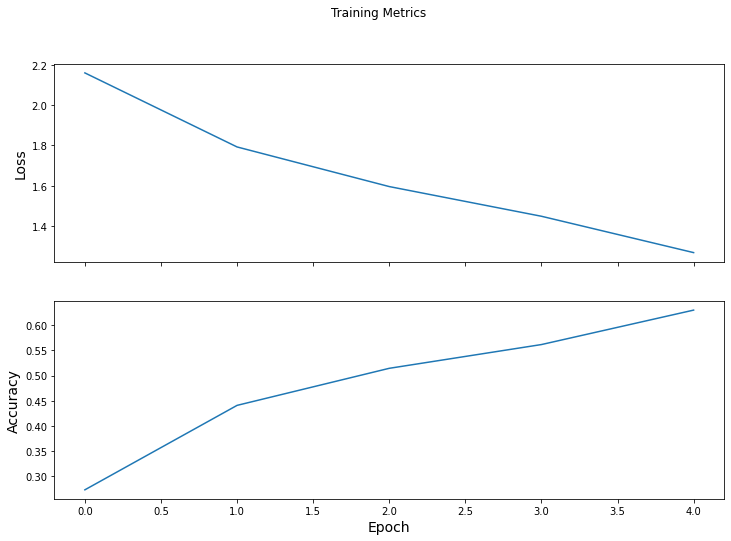

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Test Accuracy

In [24]:
test_accuracy = tf.keras.metrics.Accuracy()
# ds_test_batch = ds_test.batch(10)

for (x, y) in val_ds:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int64)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 61.044%


In [25]:
########################################################################################################################
########################################################################################################################
########################################################################################################################

In [26]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [27]:
# model.summary()

In [28]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [29]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()